# Group Number - 39

Compound - $\text{AlO}$:
- Element A is $\text{Al}$
- Element B is $\text{O}$

## Imports

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# Question 2

## Question 2.1

### Question 2.1.1 - Theoretical Questions

We can see that:
- The space group number is 225, corresponding to a FCC lattice.

- There are two inequivalent Wyckoff positions that are occupied, 4a and 4b, both have a multiplicity of 4 and both are fixed. The corresponding point group is Fm-3m.

- Formally, a point group is the the set of **fixed point** symmetry operations on an object (where the group operation is the composition of symmetries).
    
    A crystallographic point group is a point group that is compatible with some 3D lattice (for example, it needs to satisfy the crystallographic restriction theorem).
    
    Finaly, a space group is a combination of crystallographic point group with a Bravais lattice (meaning it now includes **non fixed point** operations such as translations and screw rotations).  

### Question 2.1.2 - Setting up the SCF calculation

We calculate the desired quantities:

- Sum of Atomic Radii of Na and Cl is 269pm.
- Sum of Atomic Radii of Al and O is 166pm.

Hence we will choose our lattice parameter as:
$$
\begin{align*}

a_\text{AlO} &= a_\text{NaCl} \times \frac{R_\text{Al} + R_\text{O}}{R_\text{Na} + R_\text{Cl}}
\\\\

&= 5.64 \AA \times \frac{166}{269}
\\\\

&\approx 3.48 \AA

\end{align*}
$$

In atomic units this length has numerical value $6.576$.

We create the file `AlO.scf.in`.

### Question 2.1.3 - Convergence Tests

In [158]:
# Target threshold on the energy (in Ry considering we have two atoms per unit cell)
etarget = 0.0007349859 * 2

#### Convergence on ECUT

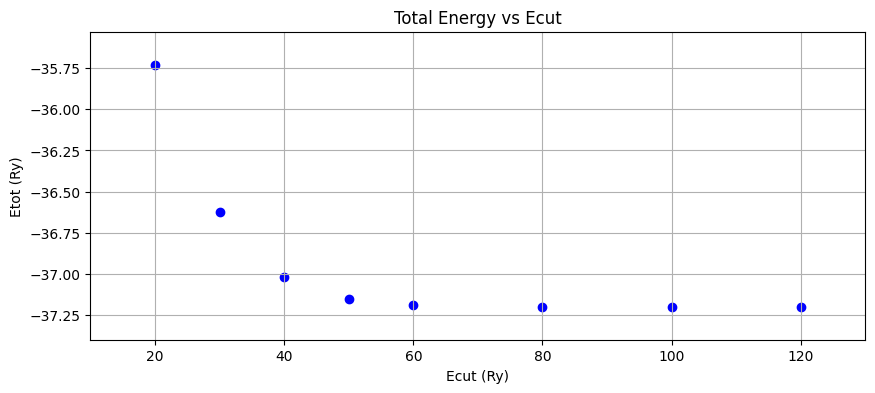

In [159]:
# ENERGY AS A FUNCTION OF ECUT

# Read the data from AlO.scf.ecut.out
kk, etot = [], []

with open('AlO.scf.ecut.out', 'r') as file:
    for line in file:
        e, t = line.split(" ")
        kk.append(int(e.split(".")[2].split("-")[1]))
        etot.append(float(t))

kk, etot = zip(*sorted(zip(kk, etot)))


# Plotting
plt.figure(figsize=(10, 4))
plt.title('Total Energy vs Ecut')
plt.scatter(kk, etot, marker='o', linestyle='-', color='b')

plt.xlabel('Ecut (Ry)')
plt.ylabel('Etot (Ry)')
plt.grid(True)

plt.xlim(min(kk) - 10, max(kk) + 10)
plt.ylim(min(etot) - 0.2, max(etot) + 0.2)

plt.show()

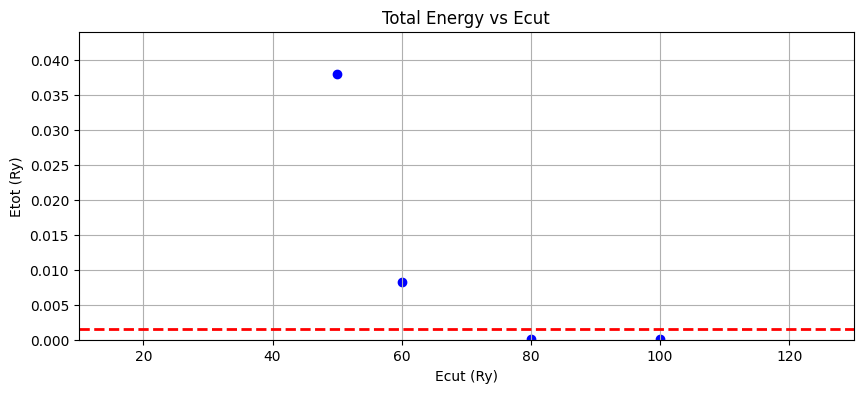

In [160]:
# CONVERGENCE ON ECUT

# Calculate Energy Differences
edelta = [abs(etot[i+1] - etot[i]) for i in range(len(kk) - 1)]

# Plotting
plt.figure(figsize=(10, 4))
plt.title('Total Energy vs Ecut')
plt.scatter(kk[:-1], edelta, marker='o', linestyle='-', color='b')

plt.xlabel('Ecut (Ry)')
plt.ylabel('Etot (Ry)')
plt.grid(True)

plt.xlim(min(kk) - 10, max(kk) + 10)
plt.ylim(0, 30 * etarget)

plt.axhline(y=etarget, color='r', linestyle='--', linewidth=2)

plt.savefig('AlO.scf.ecut.png')
plt.show()

We can see on the graphs above that:
1. The energy decreases as we increase the cutoff for the energy, as is predicted by the variational principle.
2. As we increase $E_\text{cut}$ the change in energy goes down, and we get the desired precision when $E_\text{cut} = 80\text{Ry}$ because increasing the energy further changes the energy by a value smaller then the desired precision.

#### Convergence on the K-Points

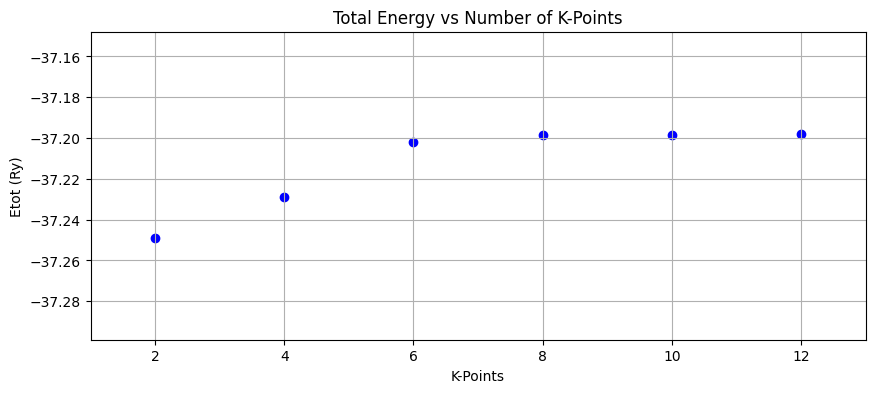

In [161]:
# ENERGY AS A FUNCTION OF THE NUMBER OF K-POINTS

# Read the data from AlO.scf.kk.out
kk, etot = [], []

with open('AlO.scf.kk.out', 'r') as file:
    for line in file:
        e, t = line.split(" ")
        kk.append(int(e.split(".")[2].split("-")[1]))
        etot.append(float(t))

kk, etot = zip(*sorted(zip(kk, etot)))


# Plotting
plt.figure(figsize=(10, 4))
plt.title('Total Energy vs Number of K-Points')
plt.scatter(kk, etot, marker='o', linestyle='-', color='b')

plt.xlabel('K-Points')
plt.ylabel('Etot (Ry)')
plt.grid(True)

plt.xlim(min(kk) - 1, max(kk) + 1)
plt.ylim(min(etot) - 0.05, max(etot) + 0.05)

plt.show()

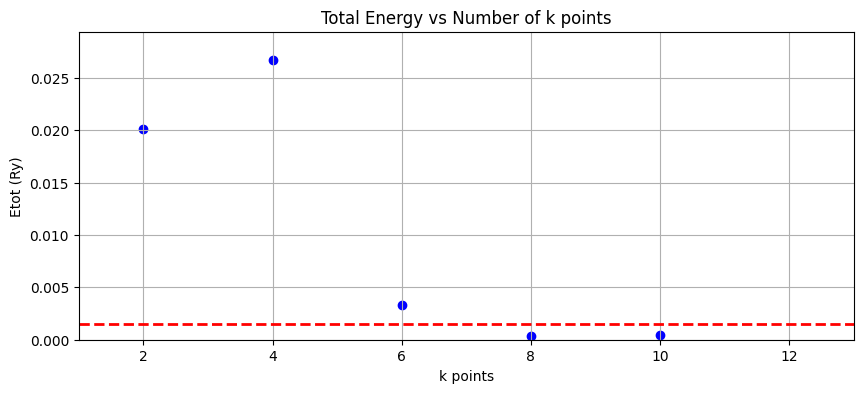

In [162]:
# CONVERGENCE ON THE NUMBER OF K-POINTS

# Calculate Energy Differences
edelta = [abs(etot[i+1] - etot[i]) for i in range(len(kk) - 1)]

# Plotting
plt.figure(figsize=(10, 4))
plt.title('Total Energy vs Number of k points')
plt.scatter(kk[:-1], edelta, marker='o', linestyle='-', color='b')

plt.xlabel('k points')
plt.ylabel('Etot (Ry)')
plt.grid(True)

plt.xlim(min(kk) - 1, max(kk) + 1)
plt.ylim(0, 20 * etarget)

plt.axhline(y=etarget, color='r', linestyle='--', linewidth=2)

plt.savefig('AlO.scf.kk.png')
plt.show()

We can see on the graphs above that:
1. There is no variational principle for the number of k-points, as they are related to how we do Brillouin zone integrals, not to the trial wave functions themselves, hence the energy can fluctuate.
2. As we increase the number of k-points the change in energy goes down, and we get the desired precision when $k = 8$ because increasing the number of k-points  further changes the energy by a value smaller then the desired precision.

As a final note, in order to ensure consistency, we used:
- $E_\text{cut} = 80\text{Ry}$ to do the converge on the k-points.
- $k = 8$ to do the converge on the cutoff energy.

## Question 2.2

### Question 2.2.1 - Structural Relaxation in Quantum Espresso

Structural Relaxation is a procedure that attempts to find the positions of the atoms within our crystal that minimize the energy of the system, that is, it atempts to find minima of the function $E(\textbf R_I)$ where $\textbf R_I$ represents the positions of the atoms.

This procedure is implemented by calculating the forces felt by each atom and using a minimization algorithm on the forces, moving the atoms to a new position where the force they feel is smaller. At equilibrium the forces will be zero.

Quantum Espresso uses the Helmann-Feynman theorem to calculate forces, giving the following result:
$$
\begin{align*}

\textbf F_{I} &= -\frac{\partial E}{\partial \textbf R_I}
\\\\

&= -{\bigg \langle }\psi\ {\bigg |}{\frac {d {H}}{d \textbf R_I}}{\bigg |}\ \psi{\bigg \rangle }
\\\\

&= \sum_iZ_I\cdot {\bigg \langle }\psi\ \bigg |\frac{\textbf r_i - \textbf R_I}{|\textbf r_i - \textbf R_I|^{3}} \bigg |\ \psi{\bigg \rangle }

\end{align*}
$$

### Question 2.2.2 - Initial Configuration

The pressure we got for our initial setup was $3180.43\text{kbar}$ (as can be seen in the `AlO.scf.out` file) and the forces acting on the atoms are as follows:

```
atom    1 type  1   force =     0.00000000    0.00000000    0.00000000
atom    2 type  2   force =     0.00000000    0.00000000    0.00000000
```

This means that the atoms are in a position that minimizes the energy for the given lattice parameters, but that the chosen lattice parameter corresponds to a pressure of $3180.43\text{kbar}$. If we relax the cell to ambient pressure we expect the volume of the unit cell to be larger (because we are reducing the pressure).

### Question 2.2.3 - Implementing Structural Relaxation

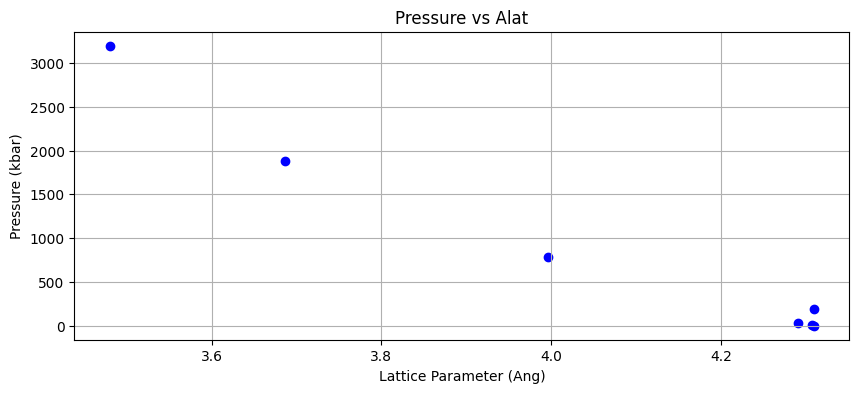

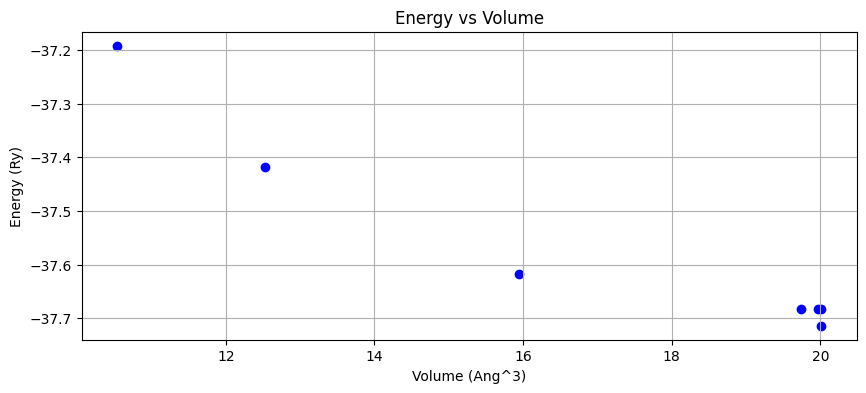

In [163]:
# PRESSURE AS A FUNCTION OF THE LATTICE PARAMETER

# Angstrom in Atomic Units
ang = 0.529177249

# Get the volume and convert to ang
vol = []
with open('AlO.vcrelax.vol.out', 'r') as file:
    for line in file:
        vol += [(float(line.split("=")[1].split()[0])) * ang**3]

# The last value is duplicated, discard it
vol = vol[:-1]

# Get the volume, multiply it by 4 and cube root it (volume of convetional cube is 4 times the volume of FCC unit cell)
alat = [(i * 4) ** (1/3) for i in vol]


# Get the pressures
pp = []
with open('AlO.vcrelax.pp.out', 'r') as file:
    for line in file:
        pp += [(float(line.split("=")[1].split()[0]))]


# Get the pressures
ee = []
with open('AlO.vcrelax.energy.out', 'r') as file:
    for line in file:
        ee += [(float(line.split("=")[1].split()[0]))]


# Plotting
plt.figure(figsize=(10, 4))
plt.title('Pressure vs Alat')
plt.scatter(alat, pp, marker='o', linestyle='-', color='b')

plt.xlabel('Lattice Parameter (Ang)')
plt.ylabel('Pressure (kbar)')
plt.grid(True)

plt.savefig('AlO.scf.pressure.png')
plt.show()



# Plotting
plt.figure(figsize=(10, 4))
plt.title('Energy vs Volume')
plt.scatter(vol, ee, marker='o', linestyle='-', color='b')

plt.xlabel('Volume (Ang^3)')
plt.ylabel('Energy (Ry)')
plt.grid(True)

plt.savefig('AlO.scf.energy.png')
plt.show()

We made two plots:
1. We should monitor how the pressure evolves as the lattice parameter changes, to ensure that we converge on the desired pressure.
2. We also monitored the energy as a function of the volume to make sure that as the volume changed the energy of the system went down (toward a minima as explained in question 2.2.1)

We should also note that at the last (rightmost) abcissa there are two points, this happens because QE does another scf calculation using the new reciprocal lattice, meaning we might get different results compared to using the reciprocal lattice of the unrelaxed crystal!

### Question 2.2.4

Given the comment at the end of the last question, because the difference in energy and pressure is very different between the two points with the same abcissa, we ran structural relaxation two more times until we obtained convergence.

### Question 2.2.5

We were able to use the full k grid we determined above.

### Question 2.2.6

We have that (from the file `AlO.vcrelax3.out`):
- Final volume: $V = 22.36934\ \AA^3$
- Final lattice parameter: $V = 4.473\ \AA$

## Question 2.3 - Electronic Properties

In [164]:
# Fermi Energy (can be extracted from 'AlO.nscf.out' QE output file)
Ef = 10.5863

## Band Structure

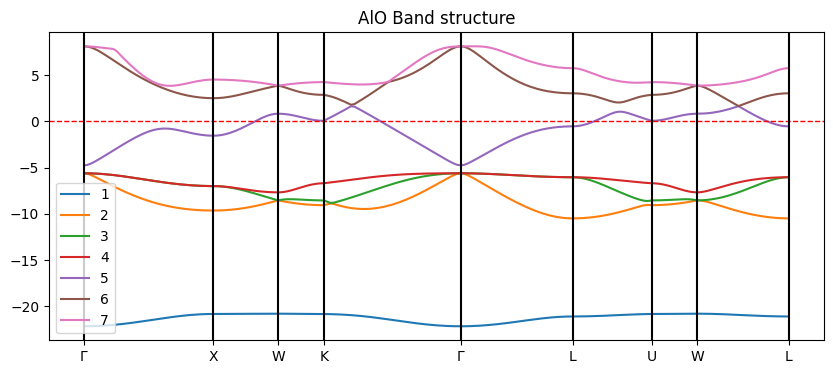

In [165]:
# Import bands data (two columns: position along x axis, energy (eV))
bands = np.loadtxt('AlO.bands.dat.gnu')

# Extract position along x-axis 
labels = [r'$\Gamma$', "X", "W", "K", r'$\Gamma$', "L", "U", "W", "L"]

# Number of bands and number of steps between each two points (in 'XX.bands.in') 
num_bands = 7
num_steps = 40

# Calculate auxiliary variables
num_kpoints = len(labels)
num_pts = (num_kpoints - 1) * num_steps + 1
posx = bands[:num_pts:num_steps, 0]

# Create the Figure
plt.figure(figsize=(10, 4))
plt.title('AlO Band structure')

plt.xticks(posx, labels)
for i in range(num_bands):
    plt.plot(bands[:num_pts, 0], bands[i*num_pts:(i+1)*num_pts, 1] - Ef, label = i+1)
    plt.legend()

# plt.ylim([-10-5.4557,20-5.4557])
# plt.ylim([-0.75,.75])

plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
for l in posx:
    plt.axvline(l, color="k")

## Density of States

Calculated number of electrons: 9.003


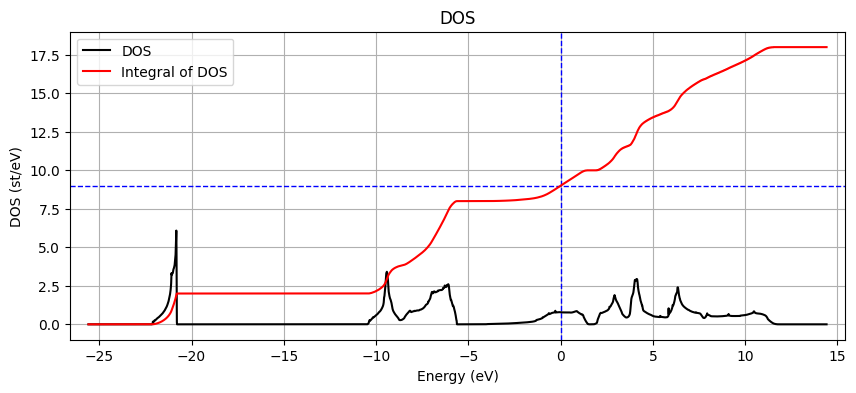

In [166]:
# Import dos data (three columns: energy (eV), dos (states/eV), IDOS (states))
dos = np.loadtxt('AlO.dos')

# Shift by the Fermi Energy
dos[:, 0] = dos[:, 0] - Ef

# Find where IDOS intersects the Fermi energy
index = list(np.abs(dos[:, 0])).index(min(np.abs(dos[:, 0])))
nelec = dos[:, 2][index]

print(f"Calculated number of electrons: {nelec}")

# Create the Figure
plt.figure(figsize=(10, 4))
plt.title('DOS')

plt.axvline(x=0, color='b', linestyle='--', linewidth=1)
plt.axhline(y=nelec, color='b', linestyle='--', linewidth=1)

# Shift all energies by Fermi energy (Make sure the values for bands and DOS are consistent!)
plt.plot(dos[:, 0], dos[:, 1], color = 'k', label="DOS")
plt.plot(dos[:, 0], dos[:, 2], color = 'r', label="Integral of DOS")
plt.legend()

plt.xlabel('Energy (eV)')
plt.ylabel('DOS (st/eV)')
plt.grid(True)

plt.xlim(np.min(dos[:, 0]) - 1, np.max(dos[:, 0]) + 1)
plt.ylim(np.min(dos[:, 2:]) - 1, np.max(dos[:, 2:]) + 1)

plt.savefig('AlO.dos.png', transparent=False, dpi=300, bbox_inches='tight')
plt.show()

## Analysis

We can see that:
1. The lowest four bands are completelly filled, and the fifth one is partially filled, using the DOS we can compute that the number of filled bands corresponds to 9 electrons per unit cell, which matches with the number of valence electrons considered in our DFT calulations (3 from Al and 6 from O as can be seen on the `AlO.scf.out` file).

2. A semicore electron is an electron which is **not** on the valence level of the atom but which is still taken into account in DFT calculations. In our system we only use the 3 electrons from n=2 for Aluminium and the 6 electrons from n=2 from Oxygen hence there are no semicore electrons. In general, this can be included in the DFT calculation via a suitable pseudopotential, if their wave function far away from the core is significant.

3. The AlO compound we are studying is a metal, because the DOS is non-zero at the Fermi energy (we have a partially filled band).

# Question 3

## Question 3.1

### Question 3.1.1 - Constructing the Conventional Cell

A FCC lattice can be described as a cubic lattice with primitive vectors $\textbf a_i = a \textbf e_i$ with the following basis:
$$

\begin{align*}

\textbf d_0 &= \textbf 0
\\\\

\textbf d_1 &= \frac12 \textbf a_1 + \frac12 \textbf a_2
\\\\

\textbf d_2 &= \frac12 \textbf a_1 + \frac12 \textbf a_3
\\\\

\textbf d_3 &= \frac12 \textbf a_2 + \frac12 \textbf a_3

\end{align*}

$$

Answering the questions:
- The volume of this conventional cell is four times the volume of the FCC primitive cell, but the latice parameters we input to quantum espresso are the same because QE uses the convetional lattice parameter of the FCC.

- In each conventional cell we have 8 atoms and 4 formula units. Our compound is described by the formula AlO meaning a formula unit is an Aluminium atom together with an oxygen atom.

- Our crystal can then be seen as two such interpenetrating FCC lattices:
    - Positions of Al atoms are the same as before:
        $$

        \begin{align*}

        \textbf d_0^{\text{Al}} &= \textbf 0
        \\\\

        \textbf d_1^{\text{Al}} &= \frac12 \textbf a_1 + \frac12 \textbf a_2
        \\\\

        \textbf d_2^{\text{Al}} &= \frac12 \textbf a_1 + \frac12 \textbf a_3
        \\\\

        \textbf d_3^{\text{Al}} &= \frac12 \textbf a_2 + \frac12 \textbf a_3

        \end{align*}

        $$
    - Positions of O atoms are given by a displacement along a half of the cubic diagonal (we add the vector associated with the 4b position of the O that we had in the FCC lattice to the vetors above):
        $$

        \begin{align*}

        \textbf d_i^{\text{O}} &= \textbf d_i^{\text{Al}} + \frac12 (\textbf a_1 + \textbf a_2 +\textbf a_3)

        \end{align*}

        $$

- We can use the Figure 1 of Appendix A to see that each Al atom has 6 nearest neighbors O atom neighbors and vice-versa, and the distance between the nn is $a / 2$ where $a$ is the lattice parameter.

### Question 3.1.2 - Running the Conventional Cell

We have setup a file called `AlO.scf.conv.in` that is the input for our SCF calculation, then we ran and we cna compare its results to the ones we have for the primitive cell:

1. The volume of this system should be 4 times the volume of the previous system, which is the result we have obtained:
    - Volume of Primitive Cell system: $150.9985 \text{(a.u.)}^3$
    - Energy of Conventional Cell system: $603.9940 \text{(a.u.)}^3$ and dividing by 4 we get $150.9985 \text{(a.u.)}^3$

2. The energy of this system should be 4 times the energy of the system using the primitive FCC lattice, because this system is 4 times bigger. This works for our calculations, within a small tolerance:
    - Energy of Primitive Cell system: $-37.72456426 \text{ Ry}$
    - Energy of Conventional Cell system: $-150.89625991 \text{ Ry}$ and dividing by 4 we get $-37.724 \text{ Ry}$


3. The pressure on both systems should be the same, which also works for our calculation, given that the calculation for the conventional cell was much less precise (we had to decrease the values of Ecut, k and convergence threshold):
    - Pressure in Primitive Cell system: $0.33 \text{ kbar}$
    - Energy of Conventional Cell system: $-76.09 \text{ kbar}$

## Question 3.2 - Vacancies

### Question 3.2.1

We have that:
- In our structure we have one vacancy per unit cell, hence 1/4 of the Al atoms missing.

- We have 3 electron per Aluminium atom and 6 per Oxygen atom, meaning that in each unit cell we have $3 \times 3 + 6 \times 4 = 33$ electrons.

- The forces acting on the atoms are all zero!

    As we could see on the output file of the previous calculation, the forces on the atoms where all zero. The atom we took out was exerting a force on all other atoms, meaning that those forces disapeered. This is equivalent to adding forces symmetric to the ones the removed atom was exerting. Because the atoms we took out form a lattice on their own, these additional symmetrical added forces will sum to zero!

    That said, the pressure is now $-398.17 \text{kbar}$ (no off-diagonal stress components), which is expected because removing an atom allows the other atoms to move closer to each other, hence we need a lower external pressure to achieve the same lattice parameter.

### Question 3.2.2

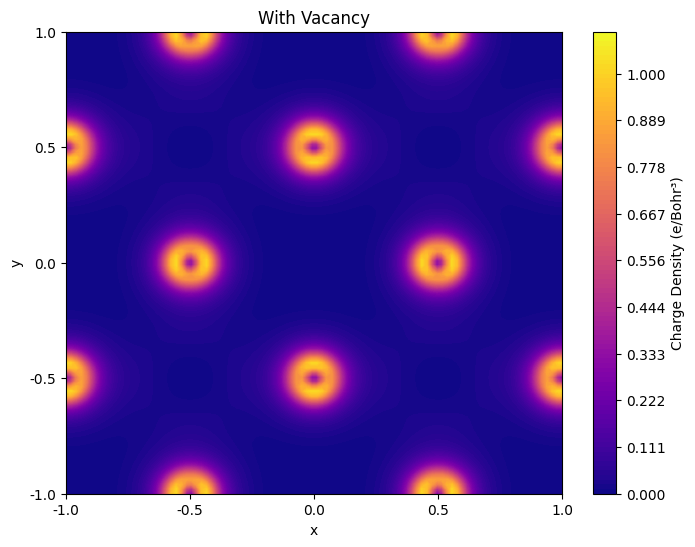

1.0144412


In [174]:
# Load the data (x, y, f(x, y)) from the file
data = np.loadtxt('cubic_001.gnuplot')

# Extract x, y, and f(x, y) values
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# Create a grid for the x and y values
nx = int(np.sqrt(len(x)))  # Number of points along one axis (assuming square grid)
ny = nx
x_grid = x.reshape((nx, ny))
y_grid = y.reshape((nx, ny))
z_grid = z.reshape((nx, ny))

# Define saturation limits for z
z_min = 0.0  # Lower bound (e.g., minimum charge density to display)
z_max = 1.1  # Upper bound (saturate above this value)

# Create the saturated colormap contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(
    x_grid, y_grid, z_grid, levels=np.linspace(z_min, z_max, 100), cmap='plasma'
)
#contour = plt.contourf(x_grid, y_grid, z_grid, levels=50, cmap='plasma', vmin=z_min, vmax=z_max)
plt.colorbar(contour, label='Charge Density (e/Bohr³)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('With Vacancy')

# Update tick labels to range from -1 to 1
plt.xticks(np.linspace(x_grid.min(), x_grid.max(), 5), np.linspace(-1, 1, 5))
plt.yticks(np.linspace(y_grid.min(), y_grid.max(), 5), np.linspace(-1, 1, 5))
plt.savefig('charge_density_vacancy.png', dpi=300, bbox_inches='tight')
plt.show()

print(np.max(z_grid))

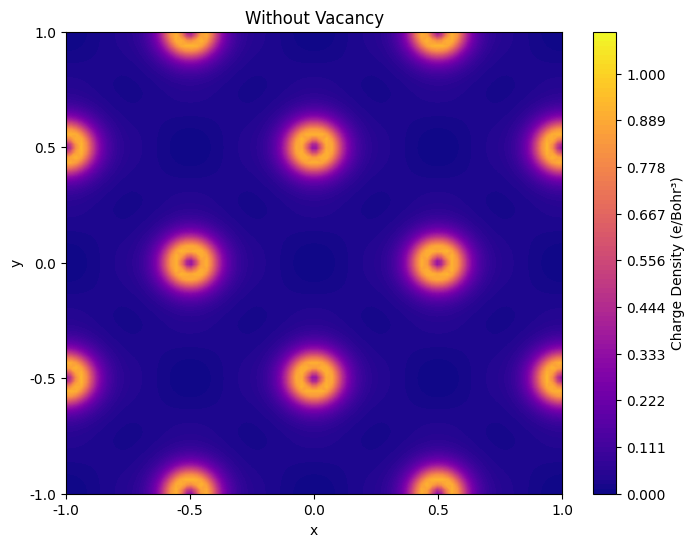

0.91633359


In [175]:
# Load the data (x, y, f(x, y)) from the file
data = np.loadtxt('cubic_002.gnuplot')

# Extract x, y, and f(x, y) values
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# Create a grid for the x and y values
nx = int(np.sqrt(len(x)))  # Number of points along one axis (assuming square grid)
ny = nx
x_grid = x.reshape((nx, ny))
y_grid = y.reshape((nx, ny))
z_grid = z.reshape((nx, ny))

# Define saturation limits for z
z_min = 0.0  # Lower bound (e.g., minimum charge density to display)
z_max = 1.1  # Upper bound (saturate above this value)

# Create the saturated colormap contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(
    x_grid, y_grid, z_grid, levels=np.linspace(z_min, z_max, 100), cmap='plasma'
)
#contour = plt.contourf(x_grid, y_grid, z_grid, levels=50, cmap='plasma', vmin=z_min, vmax=z_max)
plt.colorbar(contour, label='Charge Density (e/Bohr³)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Without Vacancy')

# Update tick labels to range from -1 to 1
plt.xticks(np.linspace(x_grid.min(), x_grid.max(), 5), np.linspace(-1, 1, 5))
plt.yticks(np.linspace(y_grid.min(), y_grid.max(), 5), np.linspace(-1, 1, 5))
plt.savefig('charge_density_vacancy.png', dpi=300, bbox_inches='tight')
plt.show()

print(np.max(z_grid))

Because the Aluminium is already less electronegative then the oxygen, removing it allows the charges to concentrate only a little bit more around the oxygen atoms.